In [1]:
import pandas as pd
import numpy as np

In [78]:
df = pd.read_excel("datos_clientes.xlsx")

In [79]:
df.head()

,Fecha,Presion,Temperatura,Volumen,Cliente
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,CLIENTE1
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,CLIENTE1
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,CLIENTE1
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,CLIENTE1
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,CLIENTE1


In [80]:
import pandas as pd
import numpy as np

# 1. Asegurar tipo datetime y ordenar
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values(by=['Cliente', 'Fecha'])

# 2. Variables de calendario / temporales
df['hour'] = df['Fecha'].dt.hour
df['day_of_week'] = df['Fecha'].dt.dayofweek
df['month'] = df['Fecha'].dt.month
df['weekofyear'] = df['Fecha'].dt.isocalendar().week.astype(int)
df['day_of_month'] = df['Fecha'].dt.day
df['day_of_year'] = df['Fecha'].dt.dayofyear
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# 3. Transformaciones cíclicas
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_dayofweek'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_dayofweek'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# 4. Turno (franjas horarias)
df['turno'] = pd.cut(df['hour'], bins=[0, 8, 16, 24], labels=['noche', 'dia', 'tarde'], right=False)
df = pd.get_dummies(df, columns=['turno'], prefix='turno')

# 5. Lags y diferencias (1h y 3h)
df['Presion_lag1'] = df.groupby('Cliente')['Presion'].shift(1)
df['DeltaPresion_1h'] = df.groupby('Cliente')['Presion'].diff(1)
df['DeltaPresion_3h'] = df.groupby('Cliente')['Presion'].diff(3)
df['DeltaVolumen_3h'] = df.groupby('Cliente')['Volumen'].diff(3)

# 6. Ventanas móviles
df['rolling_mean_presion_3h'] = df.groupby('Cliente')['Presion'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_std_presion_3h'] = df.groupby('Cliente')['Presion'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
df['rolling_mean_volumen_6h'] = df.groupby('Cliente')['Volumen'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
df['rolling_std_volumen_6h'] = df.groupby('Cliente')['Volumen'].transform(lambda x: x.rolling(window=6, min_periods=1).std())
df['rolling_min_temp_24h'] = df.groupby('Cliente')['Temperatura'].transform(lambda x: x.rolling(window=24, min_periods=1).min())
df['rolling_max_temp_24h'] = df.groupby('Cliente')['Temperatura'].transform(lambda x: x.rolling(window=24, min_periods=1).max())

# 7. Relación entre variables
df['ratio_vol_pres'] = df['Volumen'] / (df['Presion'] + 1e-6)
df['prod_vol_temp'] = df['Volumen'] * df['Temperatura']

# 8. gas_ratio y su rolling
df['gas_ratio'] = df['Presion'] * df['Volumen'] / (df['Temperatura'] + 1e-6)
df['rolling_mean_gas_ratio'] = df.groupby('Cliente')['gas_ratio'].transform(lambda x: x.rolling(window=6, min_periods=1).mean())
df['rolling_std_gas_ratio'] = df.groupby('Cliente')['gas_ratio'].transform(lambda x: x.rolling(window=6, min_periods=1).std())

# 9. Variable horas para fin de día
df['horas_para_fin_dia'] = 23 - df['hour']

# 10. Comparación con media histórica por hora del día
df['media_volumen_por_hora'] = df.groupby('hour')['Volumen'].transform('mean')
df['desv_volumen_vs_hora'] = df['Volumen'] - df['media_volumen_por_hora']

# 11. Cambio reciente (pendiente) de volumen en 3h
df['volumen_slope_3h'] = df.groupby('Cliente')['Volumen'].transform(lambda x: x.diff().rolling(3).mean())

# 12. Limpieza de nulos (por cálculos en rolling, diff, etc.)
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

df.head()

,Fecha,Presion,Temperatura,Volumen,Cliente,hour,day_of_week,month,weekofyear,day_of_month,...,rolling_max_temp_24h,ratio_vol_pres,prod_vol_temp,gas_ratio,rolling_mean_gas_ratio,rolling_std_gas_ratio,horas_para_fin_dia,media_volumen_por_hora,desv_volumen_vs_hora,volumen_slope_3h
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,CLIENTE1,0,0,1,3,14,...,28.209354,1.182556,591.543116,13.181707,13.181707,2.101082,23,64.864967,-43.895216,0.000000
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,CLIENTE1,1,0,1,3,14,...,28.518614,1.005520,508.935750,11.105805,12.143756,1.467884,22,64.637958,-46.792219,0.000000
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,CLIENTE1,2,0,1,3,14,...,28.518614,1.181148,592.154045,13.195429,12.494314,1.202503,21,64.145063,-43.169149,0.000000
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,CLIENTE1,3,0,1,3,14,...,28.518614,1.161573,572.702903,13.126186,12.652282,1.031419,20,63.286327,-42.694028,-0.125817
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,CLIENTE1,4,0,1,3,14,...,28.518614,1.222249,602.897309,13.848831,12.891592,1.041256,19,62.477584,-40.786959,1.281629


In [81]:
# Identificar columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Imputar con mediana
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Codificar el cliente
dummies = pd.get_dummies(df['Cliente'], prefix='Cliente')
df = pd.concat([df, dummies], axis=1)

df.loc[1]

Fecha                      2019-01-14 01:00:00
Presion                              17.747776
Temperatura                          28.518614
Volumen                              17.845739
Cliente                               CLIENTE1
hour                                         1
day_of_week                                  0
month                                        1
weekofyear                                   3
day_of_month                                14
day_of_year                                 14
is_weekend                                   0
sin_hour                              0.258819
cos_hour                              0.965926
sin_dayofweek                              0.0
cos_dayofweek                              1.0
turno_noche                                  1
turno_dia                                    0
turno_tarde                                  0
Presion_lag1                         17.732563
DeltaPresion_1h                       0.015213
DeltaPresion_

In [82]:
df.to_csv('anomalias.csv',index=False)

In [83]:
df = pd.read_csv('anomalias.csv')
df.head()

,Fecha,Presion,Temperatura,Volumen,Cliente,hour,day_of_week,month,weekofyear,day_of_month,...,Cliente_CLIENTE19,Cliente_CLIENTE2,Cliente_CLIENTE20,Cliente_CLIENTE3,Cliente_CLIENTE4,Cliente_CLIENTE5,Cliente_CLIENTE6,Cliente_CLIENTE7,Cliente_CLIENTE8,Cliente_CLIENTE9
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,CLIENTE1,0,0,1,3,14,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,CLIENTE1,1,0,1,3,14,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,CLIENTE1,2,0,1,3,14,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,CLIENTE1,3,0,1,3,14,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,CLIENTE1,4,0,1,3,14,...,0,0,0,0,0,0,0,0,0,0


In [84]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# 1. Selección de variables (excluimos Fecha y columnas que no aportan)
excluir = ['Fecha','Cliente']  # Si tienes otras columnas no numéricas, agrégalas aquí
X_cols = [col for col in df.columns if col not in excluir and df[col].dtype in [np.float64, np.int64]]

X = df[X_cols].copy()

# 2. Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Entrenar Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_scaled)

# 4. Predicción
df['anomaly_label'] = model.predict(X_scaled)  # 1 = normal, -1 = anomalía
df['anomaly_score'] = model.decision_function(X_scaled)  # cuanto más negativo, más anómalo

# 5. Porcentaje de anomalías detectadas
porcentaje_anomalias = (df['anomaly_label'] == -1).mean() * 100
print(f"📊 Porcentaje de anomalías detectadas: {porcentaje_anomalias:.2f}%")


📊 Porcentaje de anomalías detectadas: 5.00%



🔎 Porcentaje de anomalías por cliente:
Cliente
CLIENTE1      0.00
CLIENTE10     1.46
CLIENTE11    16.46
CLIENTE12     0.20
CLIENTE13     1.49
CLIENTE14     0.00
CLIENTE15     2.66
CLIENTE16    21.71
CLIENTE17     0.00
CLIENTE18     0.01
CLIENTE19     1.61
CLIENTE2      0.00
CLIENTE20     2.62
CLIENTE3      6.52
CLIENTE4      3.68
CLIENTE5      0.00
CLIENTE6      6.27
CLIENTE7      0.07
CLIENTE8     31.20
CLIENTE9      3.20
Name: anomaly_label, dtype: float64


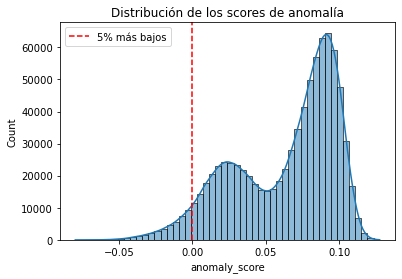

In [85]:
anom_por_cliente = df.groupby('Cliente')['anomaly_label'].apply(lambda x: (x == -1).mean() * 100)
print("\n🔎 Porcentaje de anomalías por cliente:")
print(anom_por_cliente.round(2))

import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.title("Distribución de los scores de anomalía")
plt.axvline(df['anomaly_score'].quantile(0.05), color='r', linestyle='--', label='5% más bajos')
plt.legend()
plt.show()


In [89]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Preparar X
X_cols = [col for col in df.columns if col not in ['Fecha', 'anomaly_label', 'anomaly_score','Cliente']]
X = df[X_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Búsqueda sobre diferentes valores de contamination
contamination_values = [0.01, 0.03, 0.05, 0.07, 0.10]
resultados = []

for c in contamination_values:
    print('cont: ',c)
    model = IsolationForest(n_estimators=100, contamination=c, random_state=42)
    model.fit(X_scaled)
    y_pred = model.predict(X_scaled)
    scores = model.decision_function(X_scaled)

    # Invertir: -1 = anomalía → 1; 1 = normal → 0
    anomaly_flags = (y_pred == -1).astype(int)
    porcentaje_anomalias = anomaly_flags.mean() * 100
    avg_score_anom = scores[y_pred == -1].mean()
    avg_score_normal = scores[y_pred == 1].mean()

    resultados.append({
        'contamination': c,
        'anomalías_detectadas (%)': porcentaje_anomalias,
        'anomaly_score medio (anom)': avg_score_anom,
        'anomaly_score medio (normal)': avg_score_normal
    })

# Mostrar resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df.round(3))


cont:  0.01
cont:  0.03
cont:  0.05
cont:  0.07
cont:  0.1
   contamination  anomalías_detectadas (%)  anomaly_score medio (anom)  \
0           0.01                       1.0                      -0.010   
1           0.03                       3.0                      -0.013   
2           0.05                       5.0                      -0.014   
3           0.07                       7.0                      -0.015   
4           0.10                      10.0                      -0.015   

   anomaly_score medio (normal)  
0                         0.088  
1                         0.074  
2                         0.067  
3                         0.063  
4                         0.059  
